In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.datasets import make_moons
from mlxtend.plotting import plot_decision_regions

# SVM 

In [17]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier

    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process

    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following form ndarray, shape(n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following form ndarray, shape(n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following form ndarray, shape(n_support_vectors, 1)
      Support vector label

    """
    def __init__(self, num_iter, lr, kernel='linear', gamma=1, theta=0, d=1, threshold=1e-5, verbose=False, debug=False):
        ## Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta = theta
        self.d = d
        
        self.n_support_vectors = 0
        self.index_support_vectors = None
        self.X_sv = None
        self.lam_sv = None
        self.y_sv  = None
        
        ## Debug data
        self.debug = debug
        self.my_lambda = np.array([0.3, 0.2, 0.6]).reshape(-1, 1)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form ndarray, shape (n_samples, )
            Correct answer value of training data
        X_val : The following form ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form ndarray, shape (n_samples, )
            Correct value of verification data
        """
        
        ## Whether to calculate validation data
        is_val_calc = (X_val is not None) and (y_val is not None)
        
        ## Processing and shaping data
        X, y = self._data_processing(X, y)
        
        if is_val_calc:
            X_val, y_val  = self._data_processing(X_val, y_val)
        
        ## Randomly set the initial value of λ according to the number of samples
        if self.debug:
            self._lambda = self.my_lambda
        else:
            self._lambda = np.random.rand(len(X), 1)
        
        ## Learning for the number of iterators
        for _iter in range(num_iter):
            self._lagrange(X, y)
        
            ## Output the learning process when verbose is set to True
            if self.verbose:
                print(self._lambda)
        
        ## Determining support vector
        self.index_support_vectors = np.where(self._lambda > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)

        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self._lambda[self.index_support_vectors]
        self.y_sv  = y[self.index_support_vectors]
        
        print("number of support_vector is {}".format(self.n_support_vectors))
        
    def predict(self, X):
        """
        Estimate the label using the SVM classifier.

        Parameters
        ----------
        X : The following form ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        
        X, _ = self._data_processing(X)
        
        pred = np.sum(self.lam_sv * self.y_sv * self._kernel(self.X_sv, X), axis=0).reshape(-1, 1)
        pred = np.where(pred >= 0, self.y_true, self.y_false)
        
        return pred
    
    def _kernel(self, Xi, Xj):
        if self.kernel == "linear":
            K = Xi @ Xj.T
            return K
        
        elif self.kernel == "poly":
            K = (self.gamma * (Xi @ Xj.T) + self.theta)**self.d
            return K
        
        else:
            raise ValueError("not exist {}".format(self.kernel))
            
    def _lagrange(self, X, y):
        sigma = np.sum(self._lambda.T * y * y.T * self._kernel(X, X), axis=1).reshape(-1, 1)
        self._lambda += self.lr * (1 - sigma)

        self._lambda = np.where(self._lambda < 0, 0, self._lambda)
        
    def _data_processing(self, X, y=None):
        ## If the dataset is DataFrame, Series, convert to ndarray
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        ## If the dataset is one-dimensional, convert it to two-dimensional
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)
        
        if y is not None:
            y = y.reshape(-1, 1)
        
            ## Convert the value of  y to 1, -1
            self.y_true = y.max()
            self.y_false = y.min()

            y = np.where(y == self.y_true, 1, -1)

        return X, y

# Problem 1 
## Lagrange's Steepest Descent by the Undetermined Multiplier Method

SVM learning uses Lagrange's undetermined multiplier method. Prepare the Lagrange multiplier λ for the number of samples, It will be updated by the following formula. Implement the method that does this calculation in the ScratchSVMClassifier class.

$ \ lambda_i ^ {new} = \ lambda_i + \ alpha (1-\ sum_ {j = 1} ^ {n} {\ lambda_j y_i y_j k (x_i, x_j)}) $

Where $ k (x_i, x_j) = x_ {i} ^ {T} x_j $ is a kernel function. For a linear kernel:

Let's keep this part as a separate method so that it can handle other kernel functions.

$ k (x_i, x_j) = x_ {i} ^ {T} x_j $

We will calculate the relationship between all the samples for one sample.

# Problem 2
## Determination of Support Vector

A sample whose calculated Lagrange multiplier λ is larger than the set threshold is treated as a support vector.

You will need a support vector when estimating. Write the code to determine the support vector and keep it as an instance variable.

The threshold is a hyperparameter, but it is a good idea to start with about 1e-5.

If you can output the number of support vectors, you can check whether the learning is done well.

# Problem 3

## Estimate

At the time of estimation, the features of the data to be estimated and the features of the support vector are calculated by the kernel function. The obtained sign of $ f (x) $ is the classification result.

In [18]:
## Creating a test data and making predictions
num_iter = 100
lr = 0.001

X = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
y = np.array([-1, -1, 1])

svm = ScratchSVMClassifier(num_iter=num_iter, lr=lr, verbose=True, debug=True)
svm.fit(X, y)

[[0.3204]
 [0.2492]
 [0.524 ]]
[[0.33514  ]
 [0.2846868]
 [0.4697664]]
[[0.34582638]
 [0.31035294]
 [0.43112051]]
[[0.35360954]
 [0.32898602]
 [0.40363751]]
[[0.35931333]
 [0.34258237]
 [0.3841486 ]]
[[0.36352774]
 [0.35257163]
 [0.37038449]]
[[0.36667529]
 [0.35997763]
 [0.36072002]]
[[0.36905855]
 [0.36553359]
 [0.35399137]]
[[0.37089422]
 [0.36976458]
 [0.34936507]]
[[0.37233749]
 [0.37304663]
 [0.34624424]]
[[0.37349949]
 [0.37564903]
 [0.34420142]]
[[0.37445979]
 [0.37776465]
 [0.3429305 ]]
[[0.37527541]
 [0.37953158]
 [0.34221226]]
[[0.37598716]
 [0.38104873]
 [0.3418897 ]]
[[0.37662427]
 [0.38238693]
 [0.3418504 ]]
[[0.37720766]
 [0.38359691]
 [0.34201384]]
[[0.37775235]
 [0.38471499]
 [0.34232237]]
[[0.37826905]
 [0.38576719]
 [0.34273467]]
[[0.37876547]
 [0.38677214]
 [0.3432212 ]]
[[0.37924711]
 [0.38774317]
 [0.34376076]]
[[0.3797179 ]
 [0.38868985]
 [0.34433819]]
[[0.38018069]
 [0.38961902]
 [0.34494264]]
[[0.38063748]
 [0.39053558]
 [0.34556632]]
[[0.38108973]
 [0.39144303

In [19]:
X_test = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
svm.predict(X_test)

array([[-1],
       [-1],
       [ 1]])

# Problem 4
## Learning and Estimation

Learn and estimate the scratch implementation for the binary classification of Simple Dataset 1 prepared in Sprint, an introduction to machine learning scratch.

Please check if it works properly compared to the implementation by scikit-learn.

Use scikit-learn for index values such as Accuracy, Precision, and Recall.

In [20]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [21]:
## Hyperparameters
num_iter = 500
lr = 0.001
threshold = 1e-5

## Modeling
sklearn_svc = SVC(kernel="linear")
scracth_svc = ScratchSVMClassifier(num_iter=num_iter, threshold=threshold, lr=lr, kernel="linear")

model_dict = {"sklearn": sklearn_svc, "scratch": scracth_svc}

## Test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

results = pd.DataFrame(index=range(len(model_dict)) ,columns=["model_name", "accuracy"])
i = 0

for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.loc[i, :] = [name, accuracy]
    i += 1
    
results

number of support_vector is 10


,model_name,accuracy
0,sklearn,1
1,scratch,1


Same result as sklearn

# Problem 5
## Visualization of Decision Area

In [24]:
def decision_region(X, y, model, step=0.01, title='Decision Region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    Draw the determination area of the model that learned binary classification with two-dimensional features.
    The background color is drawn from the estimated values from the trained model.
    The points on the scatter plot are training or validation data.

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        Feature value
    y : ndarray, shape(n_samples,)
        label
    model : object
        Insert the installed model of the learned model
    step : float, (default : 0.1)
        Set the interval to calculate the estimate
    title : str
        Give the text of the graph title
    xlabel, ylabel : str
        Give the text of the axis label
    target_names= : list of str
        Give a list of legends
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    
    plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=80, c="yellow", marker="o")
    
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

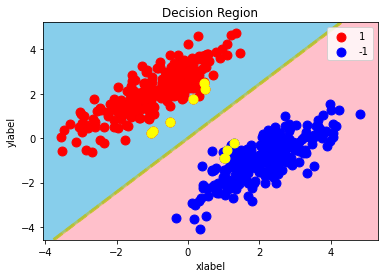

In [25]:
decision_region(X, y, scracth_svc, target_names=[1, -1])

# Problem 6
## (Advance Task) Creation of Polynomial Kernel Function

The first implementation I created used a linear kernel. Let's also switch to the polynomial kernel.

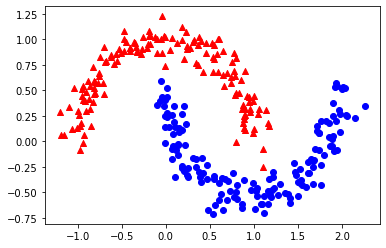

In [26]:
moons = make_moons(n_samples=300, noise=0.1, random_state=0)
X = moons[0]
y = moons[1].reshape(-1, 1)
data = np.concatenate([X, y], axis=1)
plt.scatter(data[data[:, 2] == 0][:,0], data[data[:, 2] == 0][:,1], marker="^", color="r")
plt.scatter(data[data[:, 2] == 1][:,0], data[data[:, 2] == 1][:,1], marker="o", color="b")

Let's train with a polynomial kernel using a dataset with curved boundaries as shown above.

In [27]:
## Hyperparameters
num_iter = 2000
lr = 1e-4

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc_poly = ScratchSVMClassifier(num_iter=num_iter, lr=lr ,kernel='poly', d=3, gamma=0.5, theta=1)

svc_poly.fit(X_train, y_train)

number of support_vector is 133


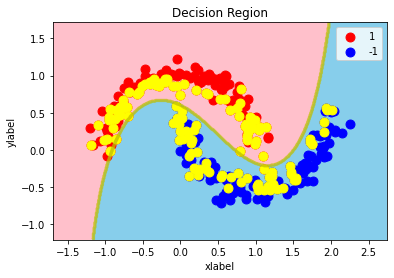

In [28]:
decision_region(X, y.flatten(), svc_poly, target_names=[1, -1])

Try drawing a border using the mlxtend module

<AxesSubplot:>

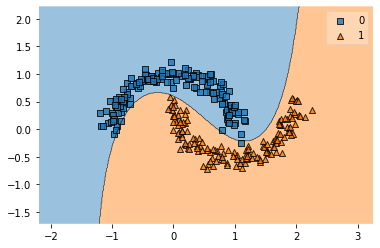

In [34]:
plot_decision_regions(X, y.flatten(), svc_poly)